## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

### Generating a dataset

In [121]:
# Generate synthetic dataset
np.random.seed(1)
N = 10000
M = 20
K = 2
EDGE_PROB=0.25
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)

### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [128]:
lm = LabelModel(k=data.k, class_balance=data.p)

lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=False,
    n_epochs=50000,
    print_every=5000,
    lr=0.001,
    l2=0
)

# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

Computing O^{-1}...
Estimating Z...
[Epoch 0] Loss: 1734.389038
[Epoch 5000] Loss: 11.303629
[Epoch 10000] Loss: 11.303629
[Epoch 15000] Loss: 11.303629
[Epoch 20000] Loss: 11.303629
[Epoch 25000] Loss: 11.303629
[Epoch 30000] Loss: 11.303629
[Epoch 35000] Loss: 11.303629
[Epoch 40000] Loss: 11.303629
[Epoch 45000] Loss: 11.303629
[Epoch 49999] Loss: 11.303629
Estimating \mu...
[Epoch 0] Loss: 49.824799
[Epoch 5000] Loss: 0.001262
[Epoch 10000] Loss: 0.000339
[Epoch 15000] Loss: 0.000102
[Epoch 20000] Loss: 0.000038
[Epoch 25000] Loss: 0.000020
[Epoch 30000] Loss: 0.000015
[Epoch 35000] Loss: 0.000014
[Epoch 40000] Loss: 0.000013
[Epoch 45000] Loss: 0.000013
[Epoch 49999] Loss: 0.000013
Average absolute error: 0.0045329880091017705


### TODOs:
* Break symmetry by initializing $\mu$ properly
* Try shuffling order of cliques?
* Try splitting into just nodes, just maximal cliques

In [129]:
# Get the condition number
O = lm.O.numpy()
np.linalg.cond(O)

311.33572

In [130]:
lm.c_data

{0: {'start_index': 0, 'end_index': 2, 'max_cliques': {18}},
 1: {'start_index': 2, 'end_index': 4, 'max_cliques': {0, 4, 8}},
 2: {'start_index': 4, 'end_index': 6, 'max_cliques': {2, 4}},
 3: {'start_index': 6, 'end_index': 8, 'max_cliques': {11}},
 4: {'start_index': 8, 'end_index': 10, 'max_cliques': {0, 6}},
 5: {'start_index': 10, 'end_index': 12, 'max_cliques': {6}},
 6: {'start_index': 12, 'end_index': 14, 'max_cliques': {12}},
 7: {'start_index': 14, 'end_index': 16, 'max_cliques': {10}},
 8: {'start_index': 16, 'end_index': 18, 'max_cliques': {9}},
 9: {'start_index': 18, 'end_index': 20, 'max_cliques': {7}},
 10: {'start_index': 20, 'end_index': 22, 'max_cliques': {2}},
 11: {'start_index': 22, 'end_index': 24, 'max_cliques': {1}},
 12: {'start_index': 24, 'end_index': 26, 'max_cliques': {16}},
 13: {'start_index': 26, 'end_index': 28, 'max_cliques': {13}},
 14: {'start_index': 28, 'end_index': 30, 'max_cliques': {5}},
 15: {'start_index': 30, 'end_index': 32, 'max_cliques':

### Trying to solve with `scipy.optimize.minimize`

In [131]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)

def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

11.303628832410334

In [134]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

1.2976160245306508e-05

In [135]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

Average absolute error: 0.004512141373699235


## Visualizing the inverse covariance matrix

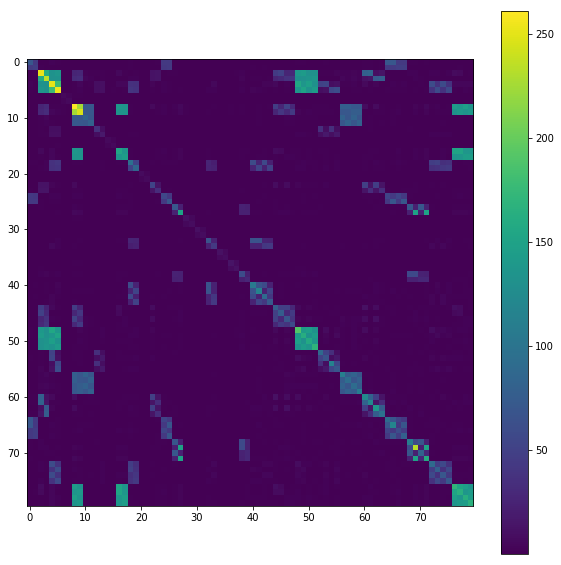

In [65]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

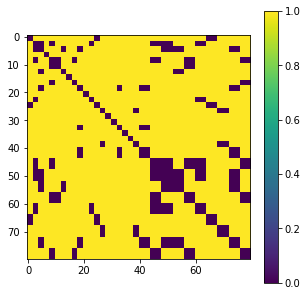

In [66]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

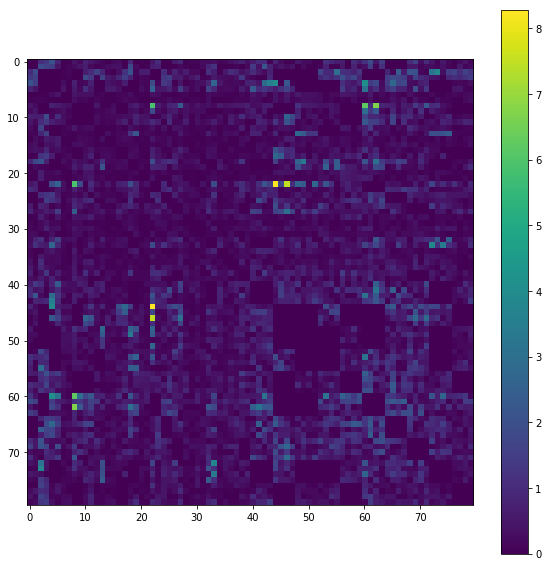

In [67]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]